# Raw ensemble Performance

This notebook is used to calculate the CRPS of the Raw Ensemble

In [1]:
import pandas as pd
import os
from tqdm import trange
import cmasher as cmr
import scipy.stats as stats

import sys
sys.path.append('../utils')
import helpers

## Data cleaning
Exclude stations above 1,000 m and with lots of missing information

In [2]:
data = pd.read_feather(os.path.join('..', 'ens_fc_t2m_complete.feather'))  # Ensemble forecasts
data2 = helpers.load_data(os.path.join('..', 'data_RL18.feather'))  # Reduced ensemble forecasts
data2.reset_index(drop=True, inplace=True)

In [3]:
wrong_to_right_id = {value:i for i,value in enumerate(data.station.drop_duplicates())}
data.station = data.station.apply(lambda x: wrong_to_right_id[x])

In [4]:
# sort by date and station
data = data.sort_values(by=['date', 'station'])
data2 = data2.sort_values(by=['date', 'station'])

In [5]:
# clean data
data2_clean = helpers.clean_data(data2)
data_clean = data.iloc[data2_clean.index]

In [6]:
# check if everything worked fine
assert all(data_clean.station == data2_clean.station.values)

## CRPS
Compute CRPS on test Data (2016)

In [7]:
from hydrostats import ens_metrics

In [8]:
data_clean = data_clean[data_clean.date.dt.year==2016]
data2_clean = data2_clean[data2_clean.date.dt.year==2016]

In [9]:
ens = data_clean.iloc[:,3:].to_numpy()
obs = data_clean.iloc[:,2].to_numpy()

In [10]:
crps = ens_metrics.ens_crps(obs, ens)

In [11]:
crpsMean_2016 = crps['crpsMean']
print(crpsMean_2016)

1.1492074238506274


## Plot

Plot of ensemble vs actual observation

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline
plt.style.use('default')
plt.rcParams.update({'font.size': 12})

In [13]:
def jitter_dots(dots):
    offsets = dots.get_offsets()
    jittered_offsets = offsets
    # only jitter in the x-direction
    jittered_offsets[:, 0] += np.random.uniform(-0.1, 0.1, offsets.shape[0])
    dots.set_offsets(jittered_offsets)

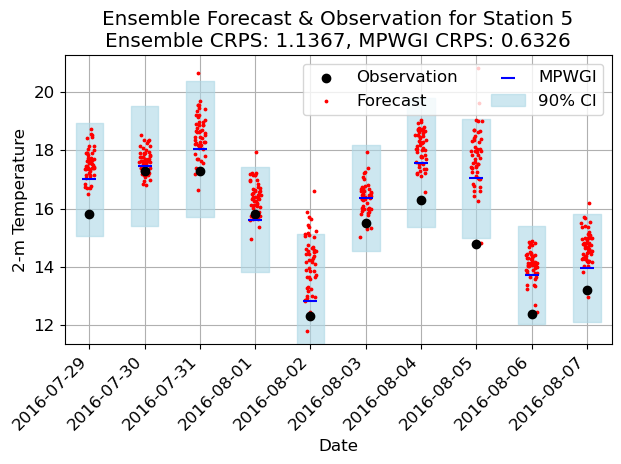

In [228]:
station = 5
days = 10
start = 210

# Add forecast from MPWGI
df_preds = pd.read_feather("../gnn/preds_GlobalInfo.feather")
df_preds = df_preds[df_preds.id == station]
df_preds = df_preds.iloc[start:start+days,:]

# Add raw ensemble
df_station = data_clean[data_clean.station == station]
df_station = df_station.iloc[start:start+days,:]

# CRPS of the n days of raw ensemble
crps = ens_metrics.ens_crps(df_station.obs.to_numpy(), df_station.iloc[:,3:53].to_numpy())
crpsMean = crps["crpsMean"]

# CRPS of the GNN
crps_GNN = df_preds.crps.mean()

# Get Forecasts
forecasts = value_vars = [col for col in df_station.columns if col.startswith('X')]
df_ens = pd.melt(df_station, id_vars=["date"], value_vars=forecasts, var_name="member", value_name="forecast")

# Plot
fig, ax = plt.subplots()

# Convert dates to numerical format
numeric_dates = mdates.date2num(df_station.date)

# Plot GNN output
# get confidence intervals
confidence_level = 0.90  # 90% confidence level
# Calculate the confidence interval
interval_width_x = 0.5


confidence_interval = stats.norm.interval(confidence_level, loc=df_preds.mu, scale=df_preds.sigma)


for i, date in enumerate(df_station.date):
    ax.fill_betweenx(
        [confidence_interval[0][i], confidence_interval[1][i]],
        numeric_dates[i] - interval_width_x / 2,
        numeric_dates[i] + interval_width_x / 2,
        alpha=0.6,
        edgecolor='none',
        color="lightblue"
    )

ax.fill_betweenx( # Hack to get the label only once in legend. This element is invisible in the plot
        [confidence_interval[0][i], confidence_interval[0][i]],
        numeric_dates[i],
        numeric_dates[i],
        alpha=0.6,
        edgecolor='none',
        color="lightblue",
        label="90% CI"
    )

# Plot scatterplot
dots = ax.scatter(df_ens.date, df_ens.forecast, s=3, label="Forecast", color="r")
jitter_dots(dots)
ax.scatter(df_station.date, df_station.obs, label="Observation", color="k")
ax.scatter(df_station.date, df_preds.mu, label="MPWGI", marker="_", s=100, color="blue")

ax.set_axisbelow(True)  # This setting places the grid lines behind the data
ax.grid(True)


plt.xlabel('Date')
plt.ylabel('2-m Temperature')
plt.title(f"Ensemble Forecast & Observation for Station {station}\nEnsemble CRPS: {'{0:.4f}'.format(crpsMean)}, MPWGI CRPS: {'{0:.4f}'.format(crps_GNN)}")

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [2,1,3,0]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncol=2)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()

#plt.savefig(f"../gnn/plots/example_wout_GNN.pdf", format='pdf', dpi=600, bbox_inches='tight')

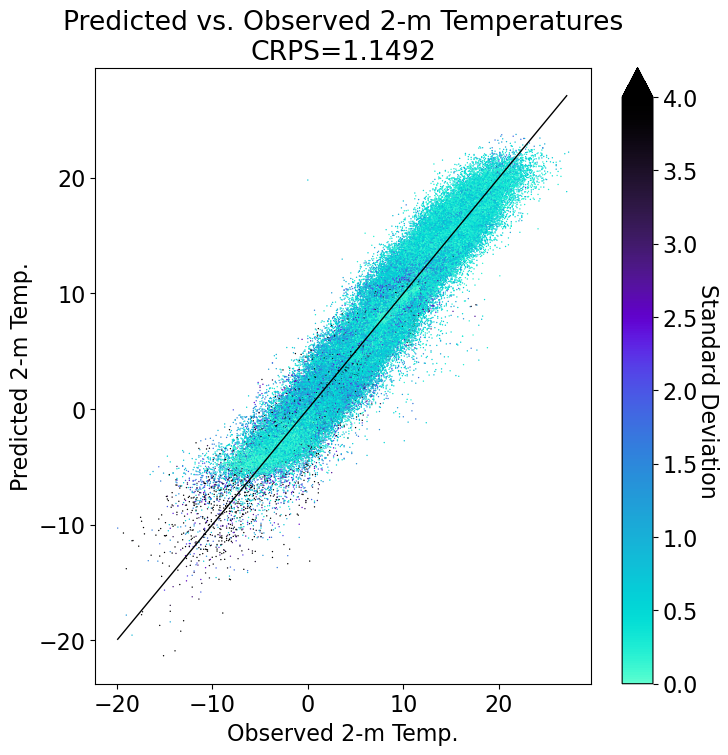

In [14]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8,8))
plt.plot(np.arange(np.min(data2_clean.obs),np.max(data2_clean.obs),1), np.arange(np.min(data2_clean.obs),np.max(data2_clean.obs),1),linewidth=1, color="black")  # line
plt.scatter(data2_clean.obs, data2_clean.t2m_mean, c=data2_clean.t2m_var, s=1, linewidth=0, cmap=cmr.cosmic_r, vmin=0, vmax=4, rasterized=True)


cbar = plt.colorbar(extend="max")
cbar.set_label('Standard Deviation', rotation=270, labelpad=15)
plt.xlabel('Observed 2-m Temp.')
plt.ylabel('Predicted 2-m Temp.')
plt.title(f"Predicted vs. Observed 2-m Temperatures\nCRPS={crpsMean_2016:.4f}")
plt.savefig(f"../gnn/plots/predsObs_raw_ensemble.pdf", dpi=600, format='pdf', bbox_inches='tight')

## CRPS vs. Temp

In [39]:
crps_per_obs = crps["crps"]
y = data2_clean.obs
# Create bins for y values from -10 to 20 with a step of 0.5
y_bins = np.arange(-20, y.max()+0.5, 0.5)

# Use digitize to assign each y value to its corresponding bin
y_bin_indices = np.digitize(y, y_bins)

# Initialize an array to store the average crps_per_obs for each bin
average_crps = np.zeros(len(y_bins) - 1)

# Calculate the average crps_per_obs for each bin
for i in range(1, len(y_bins)):
    mask = (y_bin_indices == i)
    if np.any(mask):
        average_crps[i - 1] = np.mean(crps_per_obs[mask])

# Save for multiline plot
df = pd.read_csv('../gnn/experiments/meanCRPSVsTemp.csv')
df[f"Average_CRPS_ensemble"] = average_crps
df.to_csv('../gnn/experiments/meanCRPSVsTemp.csv', index=False)

## Sigma vs.Temp

In [40]:
sigma = data2_clean.t2m_var.to_numpy()
# Initialize an array to store the average crps_per_obs for each bin
average_sigma = np.zeros(len(y_bins) - 1)

# Calculate the average crps_per_obs for each bin
for i in range(1, len(y_bins)):
    mask = (y_bin_indices == i)
    if np.any(mask):
        average_sigma[i - 1] = np.mean(sigma[mask])

# Save for multiline plot
df = pd.read_csv('../gnn/experiments/meanSigmaVsTemp.csv')
df[f"Average_SD_ensemble"] =  average_sigma
df.to_csv('../gnn/experiments/meanSigmaVsTemp.csv', index=False)

## PIT

In [18]:
from scipy.stats import norm

In [19]:
def nice_hist(data, *args, **kwargs):
    n, bins, patches = plt.hist(data, *args, **kwargs)

    # colors
    cm = cmr.get_sub_cmap(cmr.freeze,0.3,0.8)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # scale values to interval [0,1]
    col = bin_centers - min(bin_centers)
    col /= (max(col))


    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

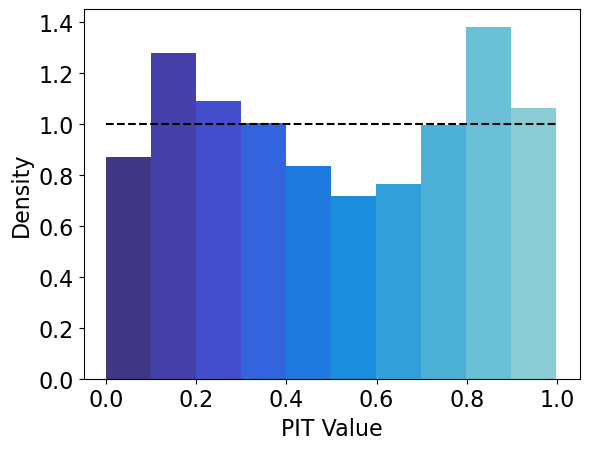

In [20]:
# Create Normal distribution based on the ensemble
mu = np.mean(ens)
sigma = np.sqrt(np.var(ens))

# Usual PIT procedure
probs = norm.cdf(obs.flatten(), loc=mu.flatten(), scale=sigma.flatten())  # scale is standard deviation
nice_hist(probs, bins=10, density=True)
plt.hlines(xmin=0,xmax=1, y=1, colors="black", linestyles="--")

plt.xlabel('PIT Value')
plt.ylabel('Density')
plt.savefig(f"../gnn/plots/PIT_raw_ensemble.pdf", format='pdf', dpi=600, bbox_inches='tight')

# Rank Histogram

In [21]:
ens_sorted = np.sort(ens, axis=1)

In [22]:
obs_b = obs[:, np.newaxis]

# Use broadcasting to find ranks for each element in the broadcasted array
ranks = np.sum(ens_sorted < obs_b, axis=1)

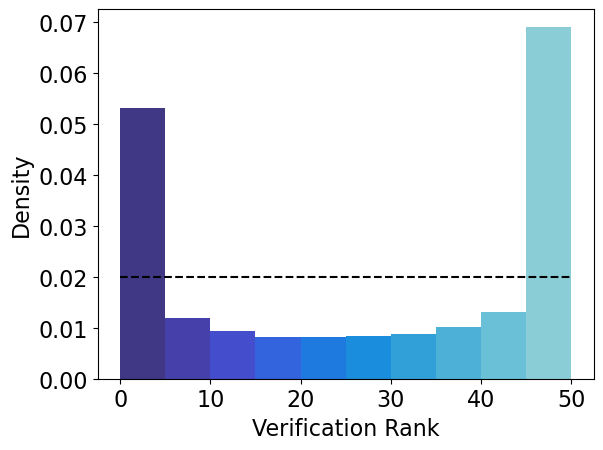

In [23]:
nice_hist(ranks, bins=10, density=True)
plt.hlines(xmin=0,xmax=50, y=1/50, colors="black", linestyles="--")
plt.xlabel('Verification Rank')
plt.ylabel('Density')
plt.savefig(f"../gnn/plots/Rank_raw_ensemble.pdf", format='pdf', dpi=600, bbox_inches='tight')